In [1]:
import xarray
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize
import seaborn as sns

In [2]:
inputs = []
basic_url = 'http://dapds00.nci.org.au/thredds/dodsC/gb6/BRAN/BRAN_2016/OFAM/ocean_eta_t_'
year = 1993
for i in range(5):
  year += 1
  month = 0
  for j in range(12):
    month += 1
    if month > 9:
      m = str(month)
    else:
      m = '0'+str(month)
    print('year: ',year,' month: ',month)
    y = str(year)
    url = basic_url + y + '_' + m + '.nc'
    data = xarray.open_dataset(url)
    eta_t = data['eta_t']
    size = eta_t.shape[0]
    for i in range(size):
      eta_t_day_i = eta_t[i,300:428,2000:2128]
      eta_t_numpy = np.array(eta_t_day_i)
      eta_t_numpy = np.nan_to_num(eta_t_numpy)
      inputs.append(normalize(eta_t_numpy,axis=1,norm='l1'))

year:  1994  month:  1
year:  1994  month:  2
year:  1994  month:  3
year:  1994  month:  4
year:  1994  month:  5
year:  1994  month:  6
year:  1994  month:  7
year:  1994  month:  8
year:  1994  month:  9
year:  1994  month:  10
year:  1994  month:  11
year:  1994  month:  12
year:  1995  month:  1
year:  1995  month:  2
year:  1995  month:  3
year:  1995  month:  4
year:  1995  month:  5
year:  1995  month:  6
year:  1995  month:  7
year:  1995  month:  8
year:  1995  month:  9
year:  1995  month:  10
year:  1995  month:  11
year:  1995  month:  12
year:  1996  month:  1
year:  1996  month:  2
year:  1996  month:  3
year:  1996  month:  4
year:  1996  month:  5
year:  1996  month:  6
year:  1996  month:  7
year:  1996  month:  8
year:  1996  month:  9
year:  1996  month:  10
year:  1996  month:  11
year:  1996  month:  12
year:  1997  month:  1
year:  1997  month:  2
year:  1997  month:  3
year:  1997  month:  4
year:  1997  month:  5
year:  1997  month:  6
year:  1997  month:  7
ye

In [3]:
inputs = np.array(inputs)

In [5]:
inputs.shape

(1826, 128, 128)

In [6]:
np.save('128x128_5years',inputs)

In [36]:
inputs[25]

array([[0.        , 0.        , 0.        , ..., 0.00701217, 0.00911686,
        0.00701217],
       [0.00883196, 0.00679304, 0.00883196, ..., 0.00679304, 0.00883196,
        0.00679304],
       [0.00883196, 0.00679304, 0.00883196, ..., 0.00679304, 0.00883196,
        0.00679304],
       ...,
       [0.00883196, 0.00679304, 0.00883196, ..., 0.00679304, 0.00883196,
        0.00679304],
       [0.00883196, 0.00679304, 0.00883196, ..., 0.00679304, 0.00883196,
        0.00679304],
       [0.00883196, 0.00679304, 0.00883196, ..., 0.00679304, 0.00883196,
        0.00679304]], dtype=float32)

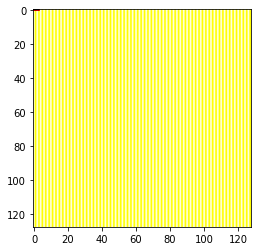

In [37]:
plt.imshow(inputs[25],cmap='hot',)
plt.show()

In [38]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Conv2D, Activation, MaxPool2D, UpSampling2D
from tensorflow.keras.layers import BatchNormalization, Flatten, Reshape, Conv2DTranspose, LeakyReLU
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, SGD

In [39]:
data_inputs = Input(shape=(128,128,1))

x = Conv2D(16,(3,3),activation='relu',padding='same')(data_inputs)
#x = BatchNormalization()(x)
x = MaxPool2D((2,2),padding='same')(x)
x = Conv2D(8,(3,3),activation='relu',padding='same')(x)
#x = BatchNormalization()(x)
x = MaxPool2D((2,2),padding='same')(x)
x = Conv2D(8,(3,3),activation='relu',padding='same')(x)
encoded = MaxPool2D((2,2),padding='same')(x)

x = Conv2D(8,(3,3),activation='relu',padding='same')(encoded)
x = UpSampling2D((2,2))(x)
x = Conv2D(8,(3,3),activation='relu',padding='same')(x)
x = UpSampling2D((2,2))(x)
x = Conv2D(16,(3,3),activation='relu',padding='same')(x)
x = UpSampling2D((2,2))(x)
decoded = Conv2D(1,(3,3),activation='relu',padding='same')(x)

autoencoder = Model(data_inputs,decoded)
autoencoder.compile(optimizer='adam',loss='mse')

In [40]:
autoencoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 128, 128, 16)      160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 8)         1160      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 8)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 8)         584       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 8)         0     

In [41]:
inputsx = np.expand_dims(inputs,axis=3)

In [45]:
np.random.shuffle(inputsx)
print(inputsx.shape)
train_inputs = inputsx[:1370,:,:,:]
val_inputs = inputsx[1370:1644,:,:,:]
test_inputs = inputsx[1644:1826,:,:,:]

(1826, 128, 128, 1)


In [46]:
history = autoencoder.fit(train_inputs, train_inputs, epochs=20,validation_data=(val_inputs,val_inputs))

Epoch 1/20
43/43 [==============================] - 36s 806ms/step - loss: 5.0656e-05 - val_loss: 4.6282e-05
Epoch 2/20
43/43 [==============================] - 34s 791ms/step - loss: 4.0240e-05 - val_loss: 4.0779e-05
Epoch 3/20
43/43 [==============================] - 34s 788ms/step - loss: 3.9085e-05 - val_loss: 4.0792e-05
Epoch 4/20
43/43 [==============================] - 35s 813ms/step - loss: 3.8759e-05 - val_loss: 4.0024e-05
Epoch 5/20
43/43 [==============================] - 34s 780ms/step - loss: 3.8442e-05 - val_loss: 3.9932e-05
Epoch 6/20
43/43 [==============================] - 34s 781ms/step - loss: 3.8348e-05 - val_loss: 3.9860e-05
Epoch 7/20
43/43 [==============================] - 33s 775ms/step - loss: 3.8290e-05 - val_loss: 3.9876e-05
Epoch 8/20
43/43 [==============================] - 33s 775ms/step - loss: 3.8205e-05 - val_loss: 3.9721e-05
Epoch 9/20
43/43 [==============================] - 33s 773ms/step - loss: 3.8128e-05 - val_loss: 3.9642e-05
Epoch 10/20
43/43 [

dict_keys(['loss', 'val_loss'])


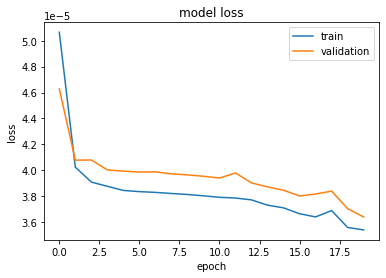

In [47]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow.keras
print(history.history.keys())

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [48]:
encoder = Model(data_inputs,encoded)

In [57]:
encoded_data = encoder.predict(np.array(test_inputs[10]))

In [58]:
encoded_data.shape

(128, 16, 1, 8)

In [63]:
decoded_data = autoencoder.predict(np.array([test_inputs[0]]))

In [55]:
decoded_data.shape

(1, 128, 128, 1)

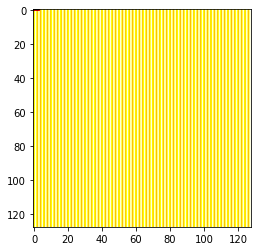

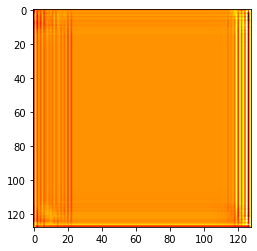

In [60]:
plt.imshow(test_inputs[10,:,:,0],cmap='hot')
plt.show()
plt.imshow(decoded_data[0,:,:,0],cmap='hot')
plt.show()

In [62]:
test_inputs[0,:,:,0]

array([[0.        , 0.        , 0.        , ..., 0.01017105, 0.00595798,
        0.01017105],
       [0.00577179, 0.00985321, 0.00577179, ..., 0.00985321, 0.00577179,
        0.00985321],
       [0.00577179, 0.00985321, 0.00577179, ..., 0.00985321, 0.00577179,
        0.00985321],
       ...,
       [0.00577179, 0.00985321, 0.00577179, ..., 0.00985321, 0.00577179,
        0.00985321],
       [0.00577179, 0.00985321, 0.00577179, ..., 0.00985321, 0.00577179,
        0.00985321],
       [0.00577179, 0.00985321, 0.00577179, ..., 0.00985321, 0.00577179,
        0.00985321]], dtype=float32)

In [64]:
decoded_data[0,:,:,0]

array([[6.8501569e-05, 8.0868434e-03, 6.0773534e-03, ..., 9.9177659e-03,
        6.6973269e-03, 1.2728211e-02],
       [2.6758201e-03, 9.5915850e-03, 5.7805125e-03, ..., 1.2985637e-02,
        5.9480639e-03, 1.1662848e-02],
       [3.8274443e-03, 9.9906782e-03, 5.5325516e-03, ..., 1.0362746e-02,
        1.1972170e-03, 9.7347517e-03],
       ...,
       [5.6907982e-03, 1.0970013e-02, 6.3754343e-03, ..., 1.0299213e-02,
        4.0750825e-03, 1.0987230e-02],
       [5.5167004e-03, 1.1669260e-02, 6.7686751e-03, ..., 1.2976455e-02,
        8.3965175e-03, 1.3276397e-02],
       [8.2437247e-03, 7.6773916e-03, 4.1125305e-03, ..., 5.6097992e-03,
        3.2214494e-03, 8.4688058e-03]], dtype=float32)